In [1]:
import os
os.chdir('..')
from utils.model import rebuild_kneenet
from utils.preprocess_image import preprocess
import torch
import torchvision
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from utils.googledrive_requests import download_from_googledrive

In [3]:
file_id = os.getenv("mendeley_dataset_file_id")

In [4]:
file_id

In [5]:
target_filepath = "data/mendeley/KneeKL299.zip"
download_from_googledrive(file_id, target_filepath)

TypeError: can only concatenate str (not "NoneType") to str

# Load Data and verify output

In [3]:
kneenet = rebuild_kneenet()

/home/rikkraan/.local/share/virtualenvs/airmex--0jxEJ_c/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [4]:
img_folders = ['data/mendeley/kneeKL299/test/' + str(x) for x in range(5)]
n_images_per_score = 1
images = []
for img_folder in img_folders:
    first_n_files = os.listdir(img_folder)[:n_images_per_score]
    for file in first_n_files:
        img = cv2.imread(os.path.join(img_folder,file), 0).astype("float")
        processed_image = preprocess(img)
        input_image = processed_image.reshape((1,) + processed_image.shape)
        input_image = torch.from_numpy(input_image)
        input_image = input_image.float()
        
        
        images.append(input_image)
        

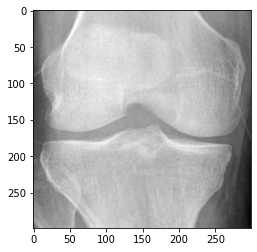

In [5]:
plt.imshow(images[0][0][0],cmap='gray')

In [6]:
images = torch.cat(images,dim=0)

In [7]:
logits = kneenet(images)

In [8]:
softmax = nn.Softmax(dim=1)

In [9]:
proba = softmax(logits).detach().numpy()

In [10]:
print(proba)

[[5.2860534e-01 2.6063386e-01 1.8894245e-01 1.7385246e-02 4.4331457e-03]
 [1.4729555e-01 6.4415880e-02 1.0122574e-01 1.5958521e-01 5.2747762e-01]
 [2.9236421e-03 8.7935114e-03 9.6412736e-01 1.8533103e-02 5.6223799e-03]
 [7.7892190e-07 7.8932142e-05 2.9485028e-03 9.9398166e-01 2.9901904e-03]
 [4.3895966e-08 3.9542268e-08 6.8152320e-07 1.5847552e-04 9.9984074e-01]]


# Test Captum Integrated Gradients

In [14]:
"""Causes kernel to die:
from captum.attr import IntegratedGradients
integrated_gradients = IntegratedGradients(kneenet,multiply_by_inputs=True)
integrated_gradients.attribute(images)
"""

'Causes kernel to die:\nfrom captum.attr import IntegratedGradients\nintegrated_gradients = IntegratedGradients(kneenet,multiply_by_inputs=True)\nintegrated_gradients.attribute(images)\n'

# Test Captum DeepLift

In [18]:
from captum.attr import DeepLift
DeepLift = DeepLift(kneenet,multiply_by_inputs=True)
attr = DeepLift.attribute(images, target=4)

/home/rikkraan/.local/share/virtualenvs/airmex--0jxEJ_c/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [19]:
attr = attr.detach().numpy()
positive_attr = attr * (attr>0)
negative_attr = -1*attr * (attr<0)
positive_attr = np.rollaxis(positive_attr,1,4)
negative_attr = np.rollaxis(negative_attr,1,4)

In [20]:
def normalize(img):
    img = img - img.min()
    img = img / img.max()
    return img

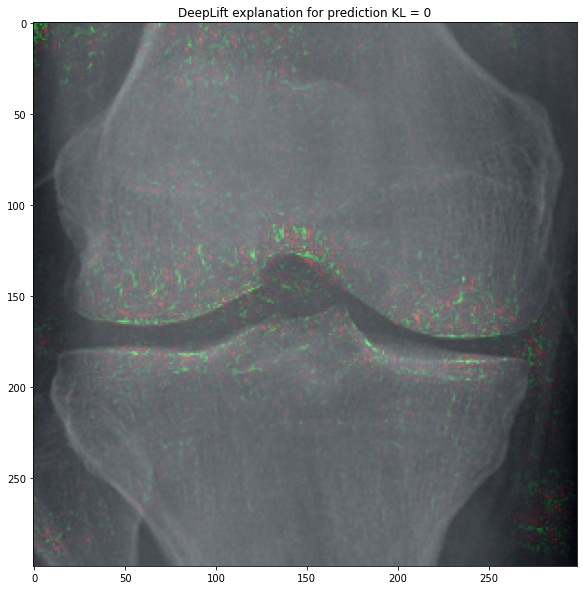

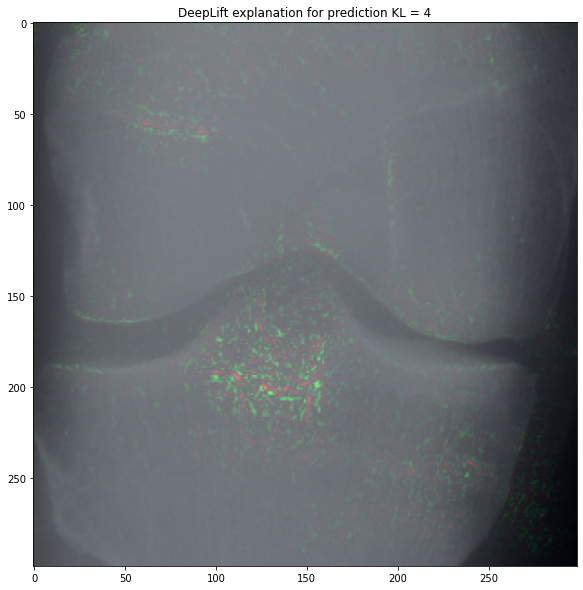

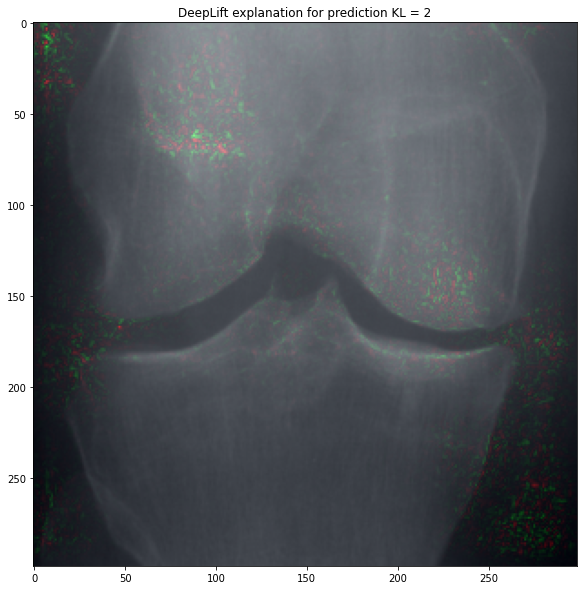

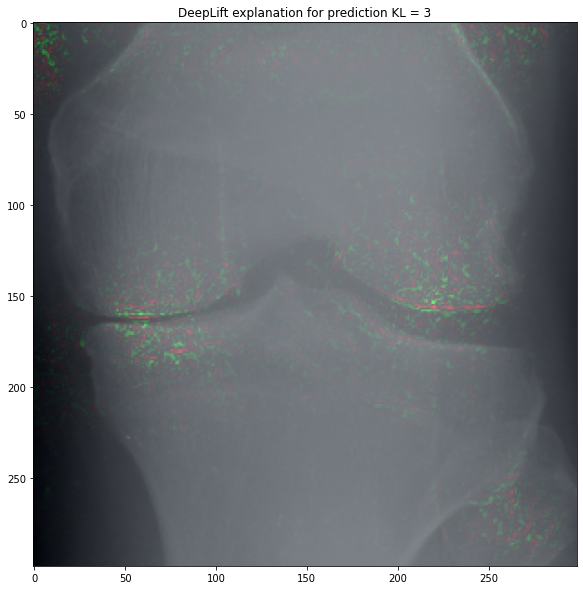

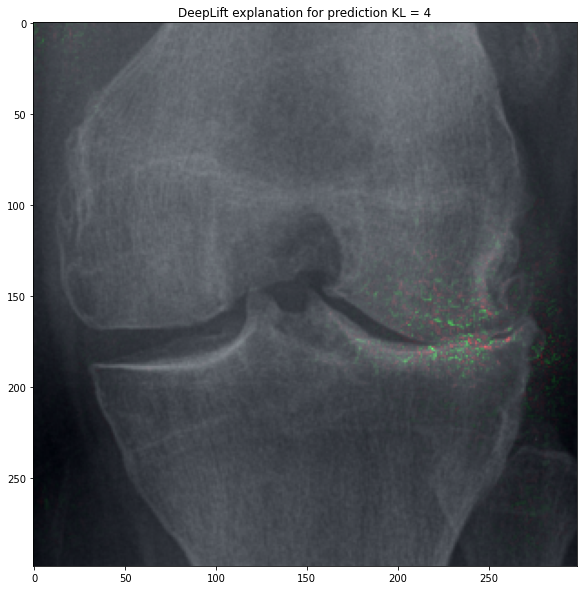

In [21]:
for image_num in range(n_images_per_score*5):
    image_n = normalize(np.rollaxis(images[image_num].detach().numpy(),0,3))
    pos_attr_n = normalize(positive_attr[image_num,:,:,0])
    neg_attr_n = normalize(negative_attr[image_num,:,:,0])
    
    
    image_n[:,:,0] = image_n[:,:,0] + pos_attr_n # Put positive attribution in the red channel
    image_n[:,:,1] = image_n[:,:,1] + neg_attr_n # Put negative attribution in the green channel
    
    # Normalize image for matplotlib
    image_n = image_n - image_n.min()
    image_n = image_n / image_n.max()
    
    # Visualize
    prediction = np.argmax(proba,axis=1)
    plt.figure(figsize=(10,10))
    plt.title("DeepLift explanation for prediction KL = " + str(prediction[image_num]))
    plt.imshow(image_n)
    
    
    

# Test Captum Guided GradCam

In [11]:
from captum.attr import GuidedGradCam
ggc = GuidedGradCam(kneenet,kneenet.features.denseblock4.denselayer32.conv2)
# get attributes for all KL-classes
attr_4 = ggc.attribute(images, target=4)
attr_3 = ggc.attribute(images, target=3)
attr_2 = ggc.attribute(images, target=2)
attr_1 = ggc.attribute(images, target=1)
attr_0 = ggc.attribute(images, target=0)

/home/rikkraan/.local/share/virtualenvs/airmex--0jxEJ_c/lib/python3.7/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/rikkraan/.local/share/virtualenvs/airmex--0jxEJ_c/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


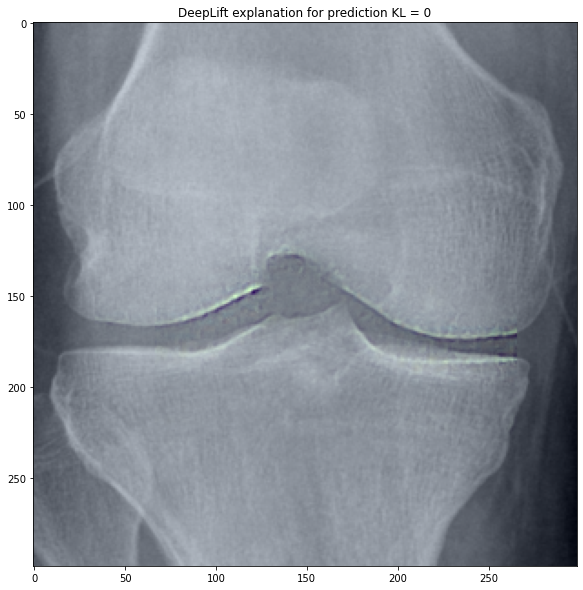

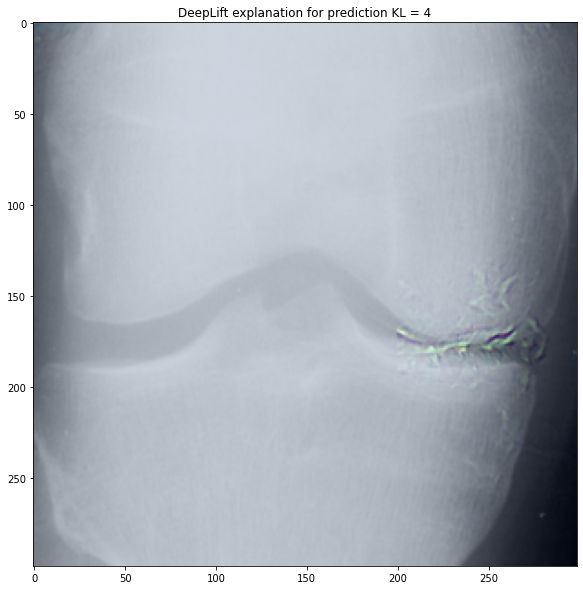

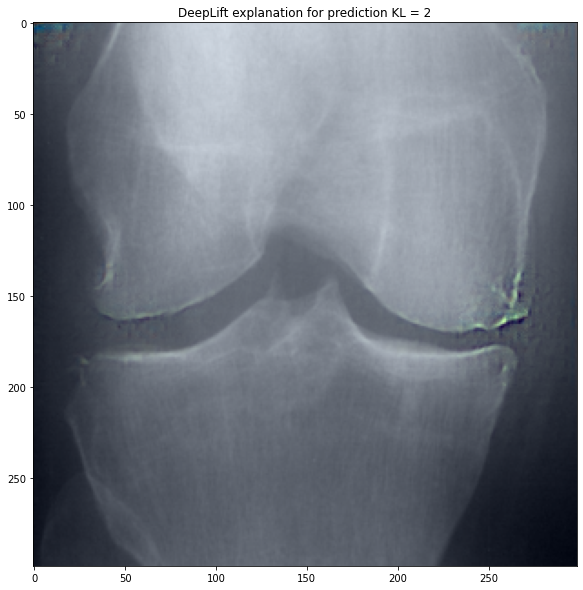

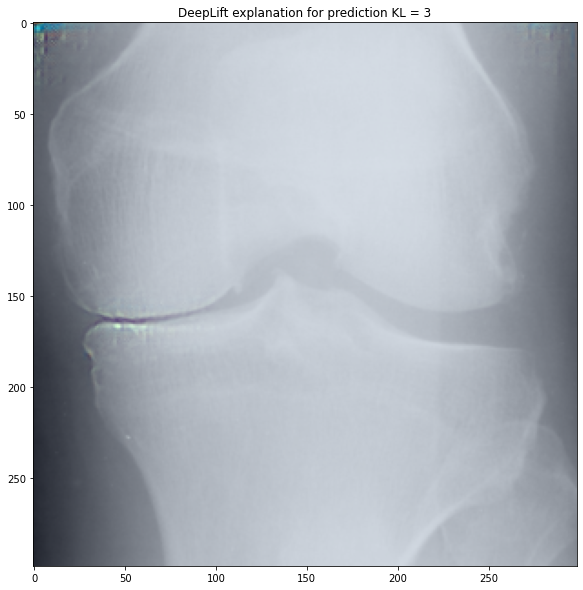

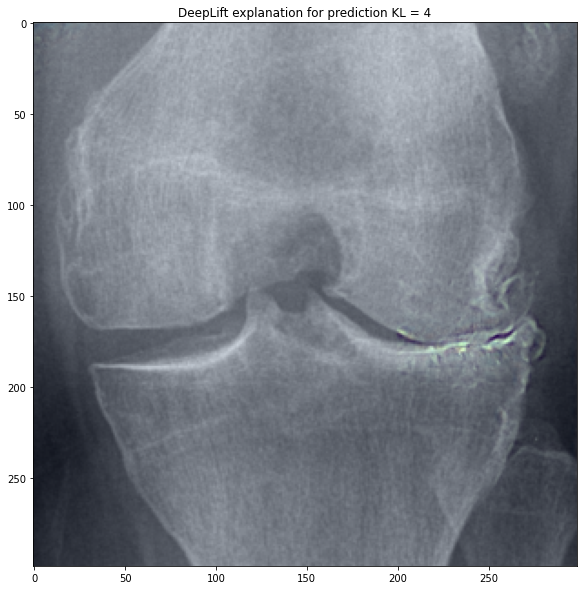

In [17]:
for image_num in range(n_images_per_score*5):
    # Get predictions for all images
    predictions = np.argmax(proba, axis=1)
    # Get the attributes for the predicted class of the current image
    attr = eval(f'attr_{predictions[image_num]}')
    
    # Normalize the image and the attributes
    image_n = normalize(images[image_num].detach().numpy()).transpose((1, 2, 0))
    attr_class = normalize(attr[predictions[image_num]].detach().numpy()).transpose((1, 2, 0))
    
    # Combine the image and the attributes
    combined_image = normalize(image_n + attr_class)
    
    # Visualize
    plt.figure(figsize=(10,10))
    plt.title("DeepLift explanation for prediction KL = " + str(predictions[image_num]))
    plt.imshow(combined_image)

In [22]:
kneenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu